# Example Script to Load, Plot, and Fit Energy Spectra

## Import needed libs:

In [1]:
import numpy as np

import matplotlib as mpl
#mpl.rcParams['mathtext.fontset'] = 'cm'
#mpl.rc('font', family='serif')

import matplotlib.pyplot as plt
import matplotlib.image as img 
from matplotlib import ticker, cm

import matplotlib.patches as patches
from matplotlib.ticker import MaxNLocator

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

import sys, code, os
import math
import random

from scipy import stats
from scipy import interpolate 
from scipy.optimize import curve_fit

from array import array

import pickle

import time

## Point to the data dir:

In [6]:
mypath = "/Users/shaoleili/Downloads/APD_data"

## Read out energy arrays from pickle files:

In [3]:
with open(mypath+'/label_energy.pkl','rb') as file:
    labels = pickle.load(file,encoding='bytes')
file.close()

with open(mypath+'/real_recon_energy.pkl','rb') as file:
    reals = pickle.load(file,encoding='bytes')
file.close()

with open(mypath+'/generated_recon_energy.pkl','rb') as file:
    gens = pickle.load(file,encoding='bytes')
file.close()

## Useful functions we will need:

In [4]:
#get chi-square and number of degrees of freedom
def my_chisq(func,popt,x,data,data_err,cutoff_l=0,cutoff_h=np.inf,pearson=False):
    chi=0
    ndf = -1.*len(popt)
    
    for i in range(0,len(data)):
        if x[i]<cutoff_l or x[i]>cutoff_h:
            continue
        diff = (func(x,*popt)[i]-data[i])**2
        err = func(x,*popt)[i] if pearson==True else data_err[i]**2
        chi = chi + diff/err
        #print diff, err, chi
        ndf = ndf + 1
    return chi, ndf

In [5]:
#make error bars and bin-centered points
def get_errs(n):
    err_list = []
    for i in range(0,len(n)):
        if n[i]!=0:
            err_i = np.sqrt(n[i])
        else:
            err_i = 1.
        err_list.append(err_i)
    return np.asarray(err_list)

def get_centers(bins,step):
    centers_list = []
    n = len(bins)-1
    for i in range(0,n):
        e_i = bins[i]+step/2.
        centers_list.append(e_i)
    return np.asarray(centers_list)

In [6]:
#fit function
def g_lin_fit(x,a,m,s,p0):
        #super inefficent way to use python:
        y = []
        for x_i in x:
            y_i= a/s/np.sqrt(2*np.pi)*np.exp(-(x_i-m)*(x_i-m)/2/s/s) + math.erf((m - x_i)/s)*p0 + p0
            y.append(y_i)
        return y

In [7]:
#get subset of array within the fit range
def get_range(cents,n,errs,left,right):
    centv         = np.vstack((cents,n)).T
    cent_err      = np.vstack((cents,errs)).T
    cent_range    = centv[((centv[:,0]>left)&(centv[:,0]<right)),0]
    n_range       = centv[((centv[:,0]>left)&(centv[:,0]<right)),1]
    err_range     = cent_err[((cent_err[:,0]>left)&(cent_err[:,0]<right)),1]
    return cent_range, n_range, err_range

## Histogram the arrays, Fit the 2.6 MeV peak with Gaus+Erf

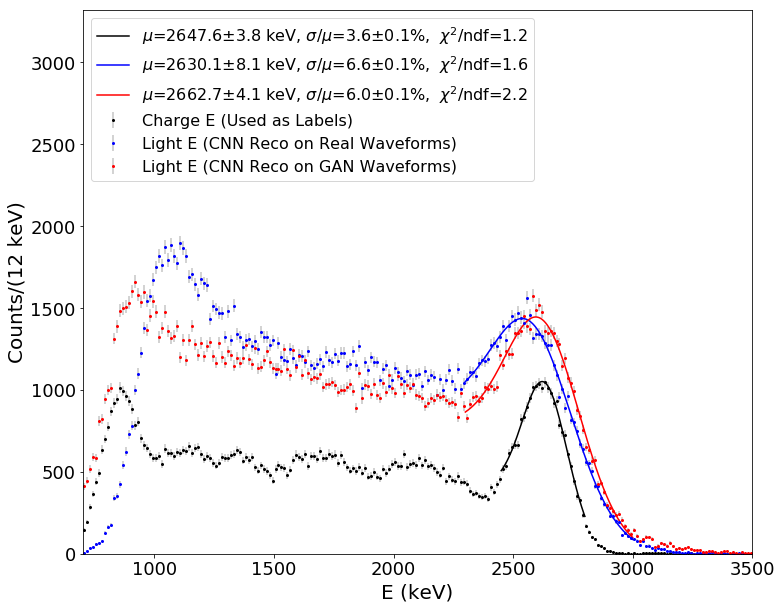

In [8]:
#set the figure size
plt.rcParams['figure.figsize'] = [12, 10]

#create binning
left = 700.
right = 3500
nbins = 224
mybins = np.linspace(left,right,nbins+1)
e_step = (right-left)/nbins

#get bin content
nlabels, bins = np.histogram(labels,bins=mybins)
nreals, bins  = np.histogram(reals, bins=mybins)
ngens, bins   = np.histogram(gens,  bins=mybins)

err_l = get_errs(nlabels)
err_r = get_errs(nreals)
err_g = get_errs(ngens)
cent  = get_centers(mybins,e_step)

#now actually plot
#plt.step(cent,nlabels,'k',where='mid',linewidth=2) #try adding this for coarse binning - may look nicer
plt.errorbar(cent,nlabels,yerr=err_l,ecolor='lightgrey',capsize=0,elinewidth=2,fmt='o',color='k',markersize=2.,label=r'Charge E (Used as Labels)')
plt.errorbar(cent,nreals,yerr=err_r,ecolor='lightgrey',capsize=0,elinewidth=2,fmt='o',color='b',markersize=2.,label=r'Light E (CNN Reco on Real Waveforms)')
plt.errorbar(cent,ngens,yerr=err_g,ecolor='lightgrey',capsize=0,elinewidth=2,fmt='o',color='r',markersize=2.,label=r'Light E (CNN Reco on GAN Waveforms)')

#Accuracy of axis labels tells people if you are a professional or a hack!
plt.xlabel(r'E (keV)',fontsize=20)
plt.ylabel(r'Counts/(%.0f keV)'%(e_step),fontsize=20)

#Set axes limits
plt.axis((left,right,0,np.max(nreals)*1.75))

#fit range
left_l  = 2450.
right_l = 2800.
left_r  = 2300.
right_r = 3000.
cent_range_l, nrange_l, err_range_l = get_range(cent,nlabels,err_l,left_l,right_l)
cent_range_r, nrange_r, err_range_r = get_range(cent,nreals,err_r,left_r,right_r)
cent_range_g, nrange_g, err_range_g = get_range(cent,ngens,err_g,left_r,right_r)
xl = np.linspace(left_l,right_l,500)
xr = np.linspace(left_r,right_r,500)
xg = np.linspace(left_r,right_r,500)


#initial parameter guess and bounds
first = (4000,2614.5,50,100)
bound=([0,2400,20,0],[np.inf,2700,300,5000])

#now fit and plot results
popt_l, pcov = curve_fit(g_lin_fit, cent_range_l, nrange_l,first, maxfev=10000,sigma=err_range_l,absolute_sigma=True,bounds=bound)
perr_l = np.sqrt(np.diag(pcov))
mychi2,ndof = my_chisq(g_lin_fit,popt_l,cent_range_l,nrange_l,err_range_l)
plt.plot(xl, g_lin_fit(xl, *popt_l), 'k-',label=r'$\mu$=%5.1f$\pm$%3.1f keV, $\sigma$/$\mu$=%1.1f$\pm$%1.1f%%,  $\chi$$^2$/ndf=%.1f' % (popt_l[1],perr_l[1],popt_l[2]/popt_l[1]*100.,perr_l[2]/popt_l[1]*100.,mychi2/ndof) )

popt_r, pcov = curve_fit(g_lin_fit, cent_range_r, nrange_r,first, maxfev=10000,sigma=err_range_r,absolute_sigma=True,bounds=bound)
perr_r = np.sqrt(np.diag(pcov))
mychi2,ndof = my_chisq(g_lin_fit,popt_r,cent_range_r,nrange_r,err_range_r)
plt.plot(xr, g_lin_fit(xr, *popt_r), 'b-',label=r'$\mu$=%5.1f$\pm$%3.1f keV, $\sigma$/$\mu$=%1.1f$\pm$%1.1f%%,  $\chi$$^2$/ndf=%.1f' % (popt_r[1],perr_r[1],popt_r[2]/popt_r[1]*100.,perr_r[2]/popt_r[1]*100.,mychi2/ndof) )

popt_g, pcov = curve_fit(g_lin_fit, cent_range_g, nrange_g,first, maxfev=10000,sigma=err_range_g,absolute_sigma=True,bounds=bound)
perr_g = np.sqrt(np.diag(pcov))
mychi2,ndof = my_chisq(g_lin_fit,popt_g,cent_range_g,nrange_g,err_range_g)
plt.plot(xg, g_lin_fit(xg, *popt_g), 'r-',label=r'$\mu$=%5.1f$\pm$%3.1f keV, $\sigma$/$\mu$=%1.1f$\pm$%1.1f%%,  $\chi$$^2$/ndf=%.1f' % (popt_g[1],perr_g[1],popt_g[2]/popt_g[1]*100.,perr_g[2]/popt_g[1]*100.,mychi2/ndof) )


plt.legend(loc='upper left',numpoints = 1,frameon=True,prop={'size': 16})
plt.gca().tick_params(labelsize=18)

#plt.savefig(mypath+'./reco_fit_check.png',bbox_inches = 'tight')

### Make 2-D plots to compare dead channels

In [9]:
with open(mypath+'/S2/real_waveform_5057.pkl','rb') as file:
    realsS2_wave = pickle.load(file,encoding='bytes')
file.close()

with open(mypath+'/S2/GAN_generated_waveform_5057.pkl','rb') as file:
    gensS2_wave = pickle.load(file,encoding='bytes')
file.close()

In [10]:
with open(mypath+'/S8/real_waveform_5828.pkl','rb') as file:
    realsS8_wave = pickle.load(file,encoding='bytes')
file.close()

with open(mypath+'/S8/GAN_generated_waveform_5828.pkl','rb') as file:
    gensS8_wave = pickle.load(file,encoding='bytes')
file.close()

In [11]:
print(realsS2_wave.shape)
print(gensS2_wave.shape)
print(realsS8_wave.shape)
print(gensS8_wave.shape)


(1767, 74, 350, 1)
(1767, 74, 350, 1)
(781, 74, 350, 1)
(781, 74, 350, 1)


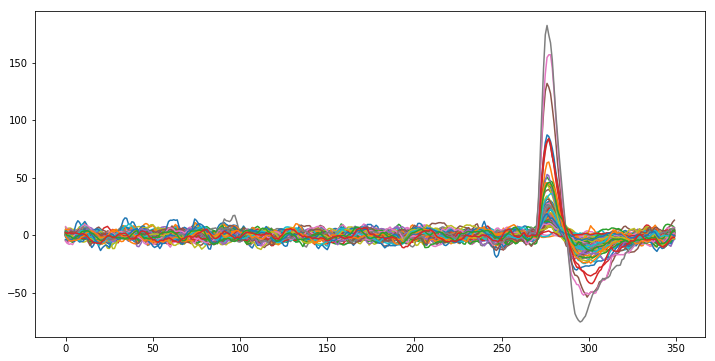

In [12]:
plt.rcParams['figure.figsize'] = [12, 6]
for i in range(0,74):
    plt.plot(gensS2_wave[0][i])

### Mini-recon

In [13]:
def getEs(apd_waves):
    totalE = 0
    EperCh1 = []
    EperCh2 = []
    bmeans = []
    brmss = []
    if len(apd_waves) != 74:
        print('too bad!')
        return -1, EperCh
    for i in range(0,74):
        bmean = np.mean(apd_waves[i][0:50])
        brms = np.std(apd_waves[i][0:50])
        bmeans.append(bmean)
        brmss.append(brms)
        e_i = np.max(apd_waves[i])
        if e_i < 3.*brms:
            e_i = 0 
        if i<37:
            EperCh1.append(e_i)
        else:
            EperCh2.append(e_i)
        totalE = totalE+e_i
    return totalE, np.asarray(EperCh1), np.asarray(EperCh2), bmeans, brmss            

### quick sanity check

1706.6612879999998


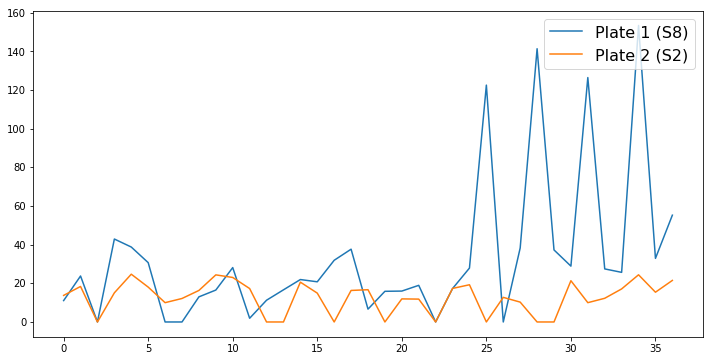

In [14]:
totalE, EperCh1,EperCh2, bmeans, brmss = getEs(realsS8_wave[2])

print(totalE)
plt.plot(EperCh1,label='Plate 1 (S8)')
plt.plot(EperCh2,label='Plate 2 (S2)')
plt.legend(loc='upper right',numpoints = 1,frameon=True,prop={'size': 16})

### more checks: E-spectrum, Baseline Mean/RMS distribution for ch.60

In [15]:
totalEs = []
bmeans60 = []
brmss60 = []
for i in range(len(realsS2_wave)):
    totalE, EperCh1, EperCh2, bmeans, brmss = getEs(realsS2_wave[i])
    totalEs.append(totalE)
    bmeans60.append(bmeans[60])
    brmss60.append(brmss[60])

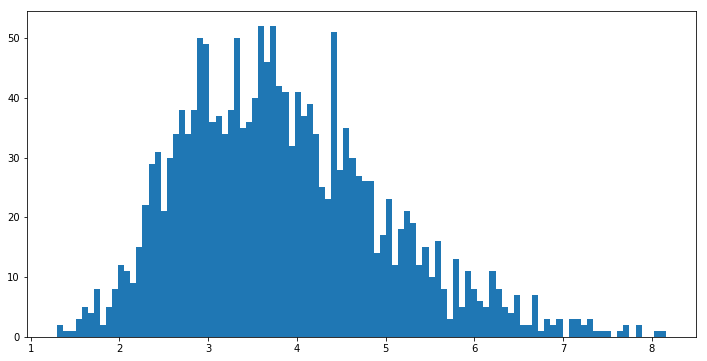

In [16]:
temp=plt.hist(brmss60,bins=100)

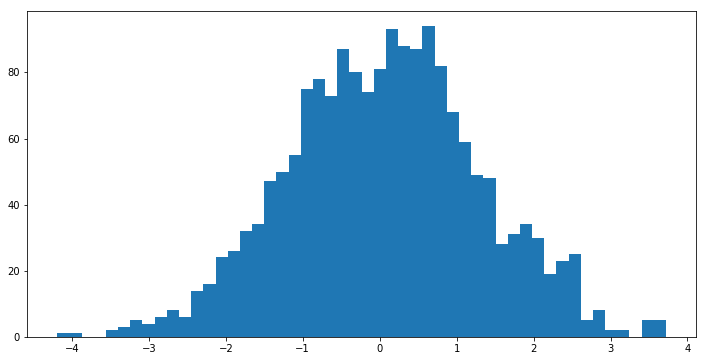

In [17]:
temp=plt.hist(bmeans60,bins=50)

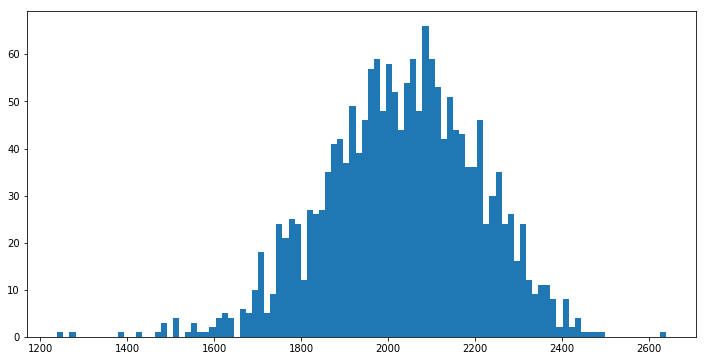

In [18]:
temp=plt.hist(totalEs,bins=100)

### Now need the channel map

In [19]:
xAPDcenter = 0 
yAPDcenter = 0
nAPDrows = 21 #number of rows of APDs
APDrowsLeft  = np.array([2,3,5,5,7,7,9,9,9,8,9,8,8,8,8,7,8,7,5,2,0]) # APDs in each row
APDrowsRight = np.array([0,2,4,7,7,7,7,8,7,8,8,8,8,9,8,7,6,5,4,3,2]) # APDs in each row    
APDnumber = 0

APD_SPACING = 2.218182 #cm
APDRADIUS = 0.8 #cm
NUMBER_APD_PER_PLANE=259
NUMBER_APD_CHANNELS_PER_PLANE = 37

fAPDx = np.zeros(NUMBER_APD_PER_PLANE)
fAPDy = np.zeros(NUMBER_APD_PER_PLANE)


for i in range(0,nAPDrows):
    for j in range(0, (APDrowsLeft[i]+1)):
        if APDrowsRight[i] != 0:
            for k in range(0, APDrowsRight[i]):
                if (j != APDrowsLeft[i]) and (k == 0):
                    fAPDy[APDnumber] = ((nAPDrows + 1.)/2. - (i + 1.)) * APD_SPACING*np.sqrt(3.)/2.
                    if APDrowsLeft[i] == 2 and APDrowsRight[i] == 0:
                        fAPDx[APDnumber] = (-APDrowsLeft[i] + j) * APD_SPACING
                    else:
                        if np.fmod(i,2.) > 0.5:
                            fAPDx[APDnumber] = (-(APDrowsLeft[i])+ 0.5 + j) * APD_SPACING
                        else:
                            fAPDx[APDnumber] = (-(APDrowsLeft[i]) + j + 1.) * APD_SPACING
                    APDnumber = APDnumber+1
                elif j == APDrowsLeft[i]:
                    fAPDy[APDnumber] = ((nAPDrows + 1.)/2. - (i + 1.)) * APD_SPACING*np.sqrt(3.)/2.
                    if np.fmod(i,2.) > 0.5:
                        fAPDx[APDnumber] = (0.5 + k) * APD_SPACING
                    else:
                        fAPDx[APDnumber] = (1. + k) * APD_SPACING
                    APDnumber = APDnumber + 1
        else:
            if j != APDrowsLeft[i]:
                fAPDy[APDnumber] = ((nAPDrows + 1.)/2. - (i + 1.)) * APD_SPACING*np.sqrt(3.)/2.
                if APDrowsLeft[i] == 2 and APDrowsRight[i] == 0:
                    fAPDx[APDnumber] = (-APDrowsLeft[i] + j) * APD_SPACING
                else:
                    if np.fmod(i,2.) > 0.5:
                        fAPDx[APDnumber] = (-(APDrowsLeft[i])+ 0.5 + j) * APD_SPACING
                    else:
                        fAPDx[APDnumber] = (-(APDrowsLeft[i]) + j + 1.) * APD_SPACING
                APDnumber = APDnumber + 1
      
    
print(APDnumber)

259


In [20]:
theta = (12-30.)*np.pi/180.
cost = np.cos(theta)
sint = np.sin(theta)
fAPDxR = np.zeros(NUMBER_APD_PER_PLANE)
fAPDyR = np.zeros(NUMBER_APD_PER_PLANE)

for i in range(0,APDnumber):
    x0 = fAPDx[i]
    y0 = fAPDy[i]
    x  = cost*x0 + sint*y0
    y  = -1.*sint*x0 + cost*y0
    fAPDxR[i]=x
    fAPDyR[i]=y

(-25, 25, -25, 25)

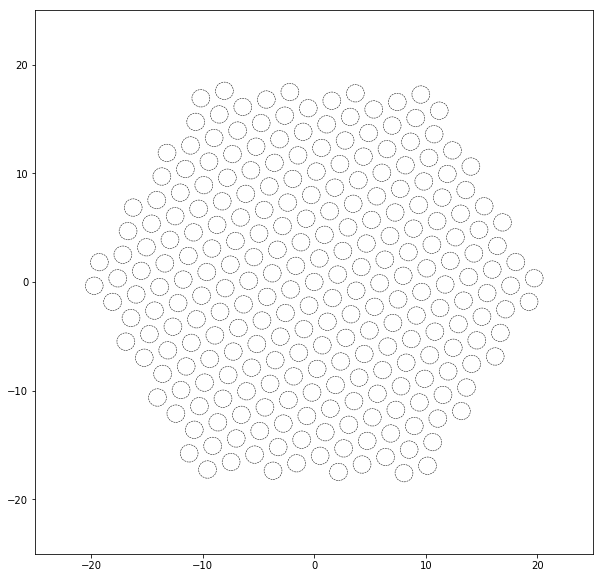

In [21]:
plt.rcParams['figure.figsize'] = [10,10]
for i in range(0,APDnumber):
    circ = plt.Circle((fAPDxR[i],fAPDyR[i]),APDRADIUS, color='k',fill=False,lw=0.5,ls='--')
    plt.gca().add_artist(circ)

plt.axis((-25,25,-25,25))

In [22]:
APDPlane1_gang_table = np.array([1,1,
                    1,1,1,2,2,
                    34,34,1,1,2,2,2,3,3,
                    34,34,34,4,4,2,2,3,3,3,7,7,
                    33,33,34,34,4,4,4,5,5,3,3,7,7,7,
                    33,33,33,36,36,4,4,5,5,5,10,10,7,7,
                    32,32,33,33,36,36,36,6,6,5,5,10,10,10,8,8,
                    32,32,32,35,35,36,36,6,6,6,12,12,10,10,8,8,8,
                    32,32,35,35,35,37,37,6,6,12,12,12,11,11,8,8,
                    27,27,35,35,37,37,37,31,31,12,12,11,11,11,9,9,
                    27,27,27,29,29,37,37,31,31,31,18,18,11,11,9,9,9,
                    27,27,29,29,29,30,30,31,31,18,18,18,16,16,9,9,
                    26,26,29,29,30,30,30,24,24,18,18,16,16,16,13,13,
                    26,26,26,28,28,30,30,24,24,24,17,17,16,16,13,13,13,
                    26,26,28,28,28,23,23,24,24,17,17,17,14,14,13,13,
                    25,25,28,28,23,23,23,22,22,17,17,14,14,14,
                    25,25,25,21,21,23,23,22,22,22,15,15,14,14,
                    25,25,21,21,21,20,20,22,22,15,15,15,
                    21,21,20,20,20,19,19,15,15,
                    20,20,19,19,19,
                    19,19])
  

APDPlane2_gang_table = np.array([20,20,
                    20,20,20,21,21,
                    16,16,20,20,21,21,21,22,22,
                    16,16,16,23,23,21,21,22,22,22,26,26,
                    15,15,16,16,23,23,23,24,24,22,22,26,26,26,
                    15,15,15,18,18,23,23,24,24,24,29,29,26,26,
                    14,14,15,15,18,18,18,25,25,24,24,29,29,29,27,27,
                    14,14,14,17,17,18,18,25,25,25,31,31,29,29,27,27,27,
                    14,14,17,17,17,19,19,25,25,31,31,31,30,30,27,27,
                    9,9,17,17,19,19,19,13,13,31,31,30,30,30,28,28,
                    9,9,9,11,11,19,19,13,13,13,37,37,30,30,28,28,28,
                    9,9,11,11,11,12,12,13,13,37,37,37,35,35,28,28,
                    8,8,11,11,12,12,12,6,6,37,37,35,35,35,32,32,
                    8,8,8,10,10,12,12,6,6,6,36,36,35,35,32,32,32,
                    8,8,10,10,10,5,5,6,6,36,36,36,33,33,32,32,
                    7,7,10,10,5,5,5,4,4,36,36,33,33,33,
                    7,7,7,3,3,5,5,4,4,4,34,34,33,33,
                    7,7,3,3,3,2,2,4,4,34,34,34,
                    3,3,2,2,2,1,1,34,34,
                    2,2,1,1,1,
                    1,1])

def get_gang_number(apd,plane):
    if plane == 0:
        gang = APDPlane1_gang_table[apd] - 1
    elif plane == 1:
        gang = APDPlane2_gang_table[apd] - 1
    else:
        gang = -999
    return gang

def get_apds_from_gang(gang_no,plane):
    apds = []
    for i in range(0,APDnumber):
        g_i = get_gang_number(i,plane)
        if g_i == gang_no:
            apds.append(i)
    return apds

In [23]:
def get_color(EperCh,i,enorm=-1):
    if enorm==-1:
        enorm = np.max(EperCh)
    shade = (enorm-EperCh[i])/enorm
    return (shade,shade,shade)

In [24]:
def plot_one_event(event,savename=''):

    plt.rcParams['figure.figsize'] = [10,5]
 
    fig1 = plt.figure()
    frame1=fig1.add_axes([0.,0.,0.5,1])
    frame1.set_xlabel('X (cm)',fontweight='bold',fontsize=20)
    frame1.set_ylabel('Y (cm)',fontweight='bold',fontsize=20)
    frame1.axis((-25,25,-25,25))
    frame1.tick_params(labelsize=14)
    
    frame2=fig1.add_axes([0.5,0,0.5,1])
    frame2.set_xlabel('X (cm)',fontweight='bold',fontsize=20)
    #frame2.set_ylabel('Y (cm)',fontweight='bold',fontsize=20)
    frame2.axis((-25,25,-25,25))
    frame2.tick_params(labelsize=14)

    totalE, EperCh1, EperCh2,bmeans, brmss = getEs(event)
    
    for i in range(0,len(EperCh1)): 
        apds1 = get_apds_from_gang(i,0)
        apds2 = get_apds_from_gang(i,1)
        for j in range(0,len(apds1)):
            circ = plt.Circle((fAPDxR[apds1[j]],fAPDyR[apds1[j]]),APDRADIUS,
                              color=get_color(EperCh1,i),fill=True,lw=0.5,ls='--')
            frame1.add_artist(circ)     
        for j in range(0,len(apds2)):
            circ = plt.Circle((fAPDxR[apds2[j]],fAPDyR[apds2[j]]),APDRADIUS,
                              color=get_color(EperCh2,i),fill=True,lw=0.5,ls='--')
            frame2.add_artist(circ)
    
    frame1.text(.05, .95, "Plate 1 (S8)", transform=frame1.transAxes, ha="left", va="top")       
    frame2.text(.05, .95, "Plate 2 (S2)", transform=frame2.transAxes, ha="left", va="top")   
    
    if savename!='':
        plt.savefig(mypath+'./'+savename+'.png',bbox_inches = 'tight')

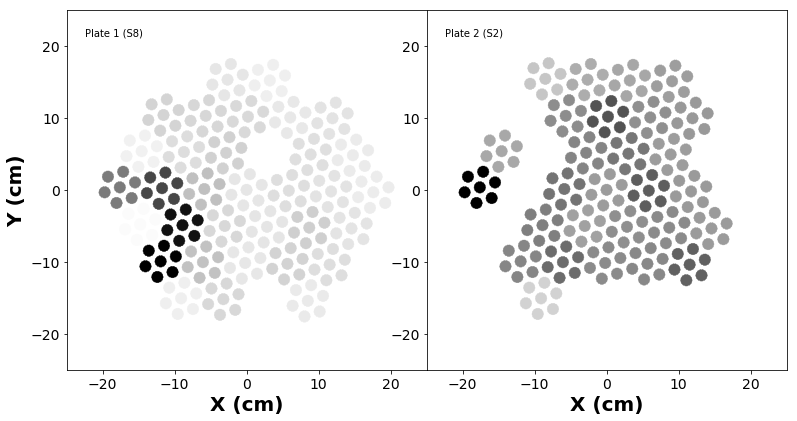

In [25]:
plot_one_event(realsS8_wave[0])

In [26]:
def plot_all_events(waves,cutoff=10,savename=''):
    plt.rcParams['figure.figsize'] = [10,5]
 
    fig1 = plt.figure()
    frame1=fig1.add_axes([0.,0.,0.5,1])
    frame1.set_xlabel('X (cm)',fontweight='bold',fontsize=20)
    frame1.set_ylabel('Y (cm)',fontweight='bold',fontsize=20)
    frame1.axis((-25,25,-25,25))
    frame1.tick_params(labelsize=14)
    
    frame2=fig1.add_axes([0.5,0,0.5,1])
    frame2.set_xlabel('X (cm)',fontweight='bold',fontsize=20)
    #frame2.set_ylabel('Y (cm)',fontweight='bold',fontsize=20)
    frame2.axis((-25,25,-25,25))
    frame2.tick_params(labelsize=14)
    
    EperCh1_tot = np.zeros(NUMBER_APD_CHANNELS_PER_PLANE)
    EperCh2_tot = np.zeros(NUMBER_APD_CHANNELS_PER_PLANE)
    for k in range(0,cutoff):
        totalE, EperCh1, EperCh2,bmeans, brmss = getEs(waves[k])
        for w in range(0,len(EperCh1)):
            EperCh1_tot[w] = EperCh1_tot[w]+EperCh1[w]
            EperCh2_tot[w] = EperCh2_tot[w]+EperCh2[w]
    enorm = np.max(EperCh1_tot)
    if np.max(EperCh2_tot) > enorm:
        enorm = np.max(EperCh2_tot)
    
    for i in range(0,len(EperCh1)): 
        apds1 = get_apds_from_gang(i,0)
        apds2 = get_apds_from_gang(i,1)
        for j in range(0,len(apds1)):
            circ = plt.Circle((fAPDxR[apds1[j]],fAPDyR[apds1[j]]),APDRADIUS,
                              color=get_color(EperCh1_tot,i,enorm),fill=True,lw=0.5,ls='--')
            frame1.add_artist(circ)     
        for j in range(0,len(apds2)):
            circ = plt.Circle((fAPDxR[apds2[j]],fAPDyR[apds2[j]]),APDRADIUS,
                              color=get_color(EperCh2_tot,i,enorm),fill=True,lw=0.5,ls='--')
            frame2.add_artist(circ)
            
    frame1.text(.05, .95, "Plate 1 (S8)", transform=frame1.transAxes, ha="left", va="top")       
    frame2.text(.05, .95, "Plate 2 (S2)", transform=frame2.transAxes, ha="left", va="top")  
    
    if savename!='':
        frame1.text(.45, .95, savename, transform=frame1.transAxes, ha="left", va="top")
        frame2.text(.45, .95, savename, transform=frame2.transAxes, ha="left", va="top")
        plt.savefig(mypath+'./'+savename+'.png',bbox_inches = 'tight')

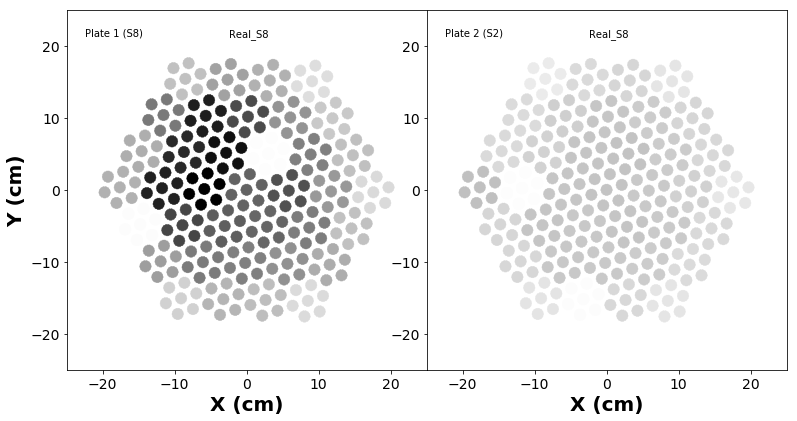

In [27]:
plot_all_events(realsS8_wave,len(realsS8_wave),savename='Real_S8')

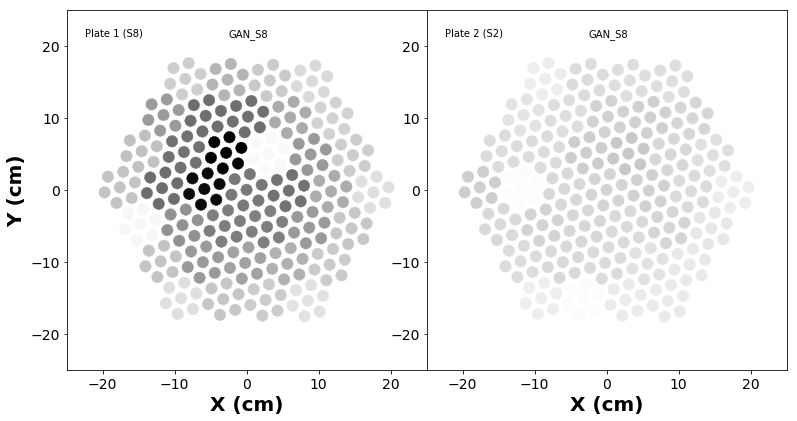

In [28]:
plot_all_events(gensS8_wave,len(gensS8_wave),savename='GAN_S8')

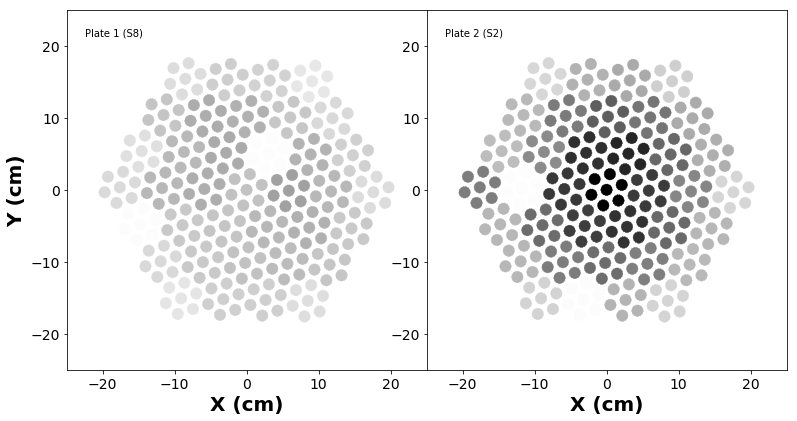

In [29]:
plot_all_events(realsS2_wave,len(realsS2_wave))

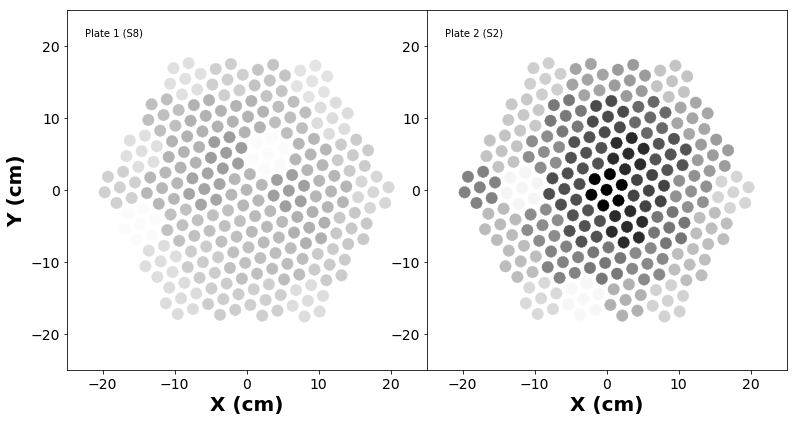

In [30]:
plot_all_events(gensS2_wave,len(gensS2_wave))